## Robôs para Armazém Inteligente
##### Baseado em Soper, 2020 (disponível em: https://youtu.be/iKdlKYG78j4)

Uma empresa de e-comerce está construindo um armazém e pretente utilzar robôs para a movimentação de material. Para isso, será necessário fazer a programação desses equipamentos. Optou-se por utilizar uma estrutura baseada em Aprendizado por Reforço (Reinforcement Learning), e a programação deverá obedecer as regras a seguir:
* O robô não deve colidir com as prateleiras;
* Deverá ser capaz de encontrar a área de entrega partindo de qualquer ponto do armazém, e vice-versa;
* Deverá encontrar o caminho mais curto entre sua localização atual e a área de entrega.
    
#### Para esta aplicação utilizaremos a abordagem de aprendizado Q-Learning, usando ações e estados discretos.
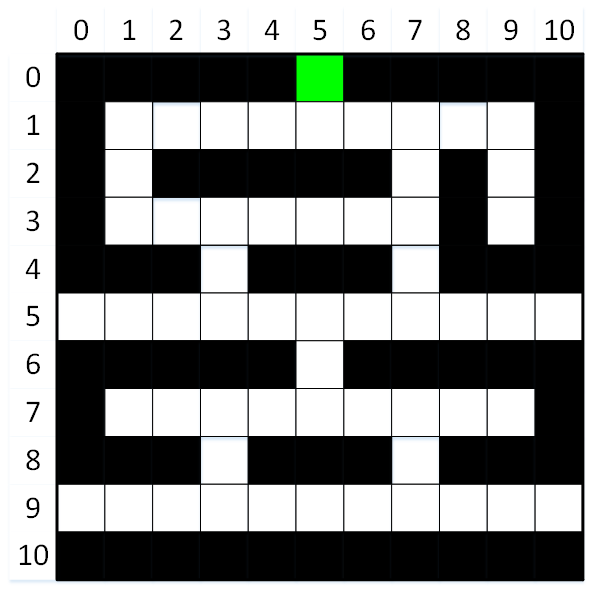



### Importando as bibliotecas

In [1]:
#import libraries
import numpy as np

### Definindo o ambiente
O ambiente consiste de **estados**, **ações** e **recompensas**. Estados e recompensas são as **entradas** para o angente, enquanto que as ações são as suas **saídas**.

#### Estados:
Os estados são todas as possívels posições dentro do armazém. Algumas são para armazenamento (marcadas em preto), enquanto que as marcadas em branco são os corredores que o robô pode utilizar para de deslocar dentro do galpão. A área de armazenamento está marcada em **verde**. As áreas pretas e a verde são **estados terminais**, encerrando a rodada de aprendizado.

#### Ações
As possíveis ações que o robô poderá realizar serão:
* Up
* Right
* Down
* Left


Como pode ser visto na imagem a cima, temos 121 estados possíveis. Podemos definir o ambiente como uma matriz de 11x11, com cada localização é identificada por sua linha e sua coluna. As ações são num total de 4.

In [2]:
# Definindo o ambiente (estados)
environment_rows = 11
environment_columns = 11
num_actions = 4

Vamos criar a estrutura que irá conter a nossa tabela Q (Q-table), sendo que, para cada estado, é possível realizar quatro ações (**Q(s,a)**). Esta matriz tridimensional será iniciada com valores iguais a zero (0).

In [22]:
# Criando a tabela Q(s,a)
q_values = np.zeros((environment_rows, environment_columns, num_actions))

In [23]:
# Definindo as ações numericamente: 0 = up, 1 = right, 2 = down, 3 = left
actions = ['up', 'right', 'down', 'left']

#### Rewards
As recompensas serão definidas conforme a figura abaixo. Usaremos recompensas negativas (punições) para evitar que o agente ande em círculos e nunca encontre o destino desejado. Além disso, punições fará com que o agente tente encontrar o menor caminho possível, reduzindo, assim, o valor das punições (maximizando as recompensas).
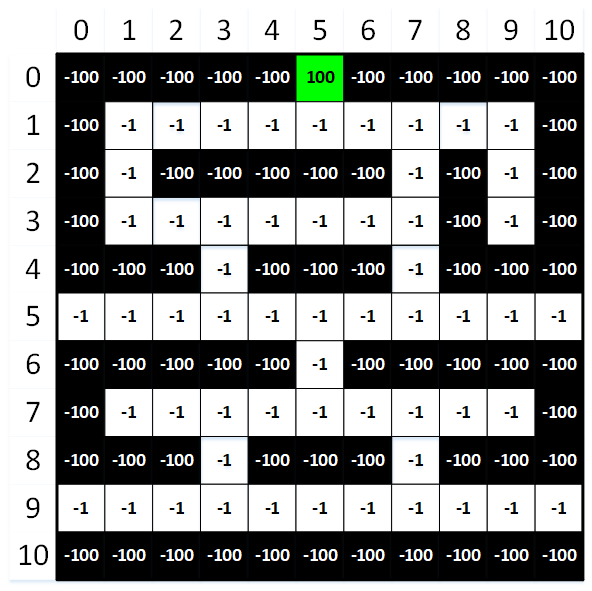


In [24]:
# Criando a matriz 2D para armazenas o valor das recompensas de cada estado
rewards = np.full((environment_rows, environment_columns), -100.)
rewards[0, 5] = 100. #set the reward for the packaging area (i.e., the goal) to 100

#define aisle locations (i.e., white squares) for rows 1 through 9
aisles = {} #store locations in a dictionary
aisles[1] = [i for i in range(1, 10)]
aisles[2] = [1, 7, 9]
aisles[3] = [i for i in range(1, 8)]
aisles[3].append(9)
aisles[4] = [3, 7]
aisles[5] = [i for i in range(11)]
aisles[6] = [5]
aisles[7] = [i for i in range(1, 10)]
aisles[8] = [3, 7]
aisles[9] = [i for i in range(11)]

#set the rewards for all aisle locations (i.e., white squares)
for row_index in range(1, 10):
  for column_index in aisles[row_index]:
    rewards[row_index, column_index] = -1.
  
#print rewards matrix
for row in rewards:
  print(row)


[-100. -100. -100. -100. -100.  100. -100. -100. -100. -100. -100.]
[-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.]
[-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100. -100. -100.]
[-100.   -1. -100. -100. -100. -100. -100.   -1. -100.   -1. -100.]
[-100. -100. -100.   -1. -100. -100. -100.   -1. -100. -100. -100.]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[-100. -100. -100. -100. -100.   -1. -100. -100. -100. -100. -100.]
[-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.]
[-100. -100. -100.   -1. -100. -100. -100.   -1. -100. -100. -100.]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[-100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.]


## Treinando o Modelo
Para imprementar o algoritmo de aprendizado Q-Learning, utilizaremos os seguintes passos:

1. Escolher aleatoriamente um estado inicial que não seja um estado terminald (preto ou verde) para o início do episódio.
2. Escolher uma ação (mover *up*, *right*, *down*, or *left*) para o estado atual. As ações serão escolhidas utilizando o algoritmo epsilo greedy (e-greedy), que permite a escolha da melhor ação para um dado estado na maioria das vezes, sendo que, evetualmente, uma ação diferente pode ser selecionada, encorajando a exploração do ambiente.
3. Realiza a ação e vai para o próximo estado (move para a próxima posição).
4. Recebe a recompensa e calcula o TD (temporal difference).
5. Atualiza a tabele Q-value para o para estado/ação anterior.
6. Se o estado atual for um estado terminal, ele retorna para o inícil, (itém #1), caso contrário, segue a partir da opção #2.

Este processo será repetido por 1000 episódios, dando oportunidade suficiente para que o agente aprenda o menor caminho, enquanto aprende a não se chocar com as prateleiras.

#### Definindo algumas funções auxiliares

In [25]:
def is_terminal_state(current_row_index, current_column_index):
    """
    Função que avalia se a localização é um estado terminal. Se a recompensa for -1, é um estado válido.
    """
    
    if rewards[current_row_index, current_column_index] == -1.:
        return False
    else:
        return True

#define a function that will choose a random, non-terminal starting location
def get_starting_location():
    """
    Função que escolhe o estado inicial de cada época de treinamento de maneira aleatória.
    """
    # escolhe uma linha e uma coluna aleatória
    current_row_index = np.random.randint(environment_rows)
    current_column_index = np.random.randint(environment_columns)
    
    # Verifica se é um estado válido (quadrado branco).
    while is_terminal_state(current_row_index, current_column_index):
        current_row_index = np.random.randint(environment_rows)
        current_column_index = np.random.randint(environment_columns)

    return current_row_index, current_column_index

#define an epsilon greedy algorithm that will choose which action to take next (i.e., where to move next)
def get_next_action(current_row_index, current_column_index, epsilon):
    """
    Escolhe uma ação com base no algoritmo epsilon greedy.
    """
    
    # Se a escolha randomica entre 0 e 1 for menor que epsilon, escolhe o estado com valor mais promissor
    if np.random.random() < epsilon:
        return np.argmax(q_values[current_row_index, current_column_index])
    else: 
        # seleciona uma ação aleatória
        return np.random.randint(4)

#define a function that will get the next location based on the chosen action
def get_next_location(current_row_index, current_column_index, action_index):
    """
    Função que define a próxima localização com base na ação selecionada.
    """
    
    new_row_index = current_row_index
    new_column_index = current_column_index
    
    if actions[action_index] == 'up' and current_row_index > 0:
        new_row_index -= 1
    elif actions[action_index] == 'right' and current_column_index < environment_columns - 1:
        new_column_index += 1
    elif actions[action_index] == 'down' and current_row_index < environment_rows - 1:
        new_row_index += 1
    elif actions[action_index] == 'left' and current_column_index > 0:
        new_column_index -= 1
    
    return new_row_index, new_column_index

def get_shortest_path(start_row_index, start_column_index):
    """
    Função que retorna o menor caminho entre qualquer localização e a área de entrega.
    """
    # Retorna vazio se for uma localização inválida
    if is_terminal_state(start_row_index, start_column_index):
        return []
  
    else: 
        # para localizaçõe válidas
        current_row_index, current_column_index = start_row_index, start_column_index
        shortest_path = []
        shortest_path.append([current_row_index, current_column_index])

    # continua se movendo ao longo do caminho até encontrar o objetivo
    while not is_terminal_state(current_row_index, current_column_index):
        # escolhe a melhor ação 
        action_index = get_next_action(current_row_index, current_column_index, 1.)
        
        # move até a próxima localização no caminho, adicionando a nova localização à lista
        current_row_index, current_column_index = get_next_location(current_row_index, current_column_index, action_index)
        shortest_path.append([current_row_index, current_column_index])

    return shortest_path

#### Podemos veriricar o comportamento do agente antes do treinamento:
* Origem: [9,10]

In [26]:
path = get_shortest_path(9,10)
print('Caminho até a área de entrega:\n',path)

#### Training Agent model

Caminho até a área de entrega:
 [[9, 10], [8, 10]]


In [28]:
# Definindo os parâmetros de treinamento
epsilon = 0.9 # percentual de vezes que irá escolher a melhor ação ao invés de uma ação aleatória
discount_factor = 0.9 # fator de desconteo para recompensas futuras
learning_rate = 0.9 # taxa de aprendizado
epochs = 1000

# Realizando treinamento durante 1000 episódios
for episode in range(epochs):
    # pega localização inicial para o episódio
    row_index, column_index = get_starting_location()

    # toma ações até que chegue a um estado terminal (área de entrega ou colisão com prateleiras)
    while not is_terminal_state(row_index, column_index):
        # escolhe uma ação
        action_index = get_next_action(row_index, column_index, epsilon)

        # realiza a ação, fazendo a transição para o próximo estado (vai para o próximo estado)
        old_row_index, old_column_index = row_index, column_index # armazena a posição anterior
        row_index, column_index = get_next_location(row_index, column_index, action_index)

        # recebe a recompensa por de deslocar para o novo estado e calcula a TD
        reward = rewards[row_index, column_index]
        old_q_value = q_values[old_row_index, old_column_index, action_index]
        temporal_difference = reward + (discount_factor * np.max(q_values[row_index, column_index])) - old_q_value

        # atualiza a tabela Q para o par estado-ação anterior
        new_q_value = old_q_value + (learning_rate * temporal_difference)
        q_values[old_row_index, old_column_index, action_index] = new_q_value

print('Training complete!')

Training complete!


## Selecionando o menor caminho
Agora que o agente já foi completamente treinado, podemos verificar a qualidade do treinamento, verificando se o caminho sugerido é o menor, se chega até a área de entrega e se não há colisão com as prateleiras.

In [29]:
# Testado para a posição sugerida anteriormente
print('Origem:\nLinha: 9 / Coluna: 10\n',get_shortest_path(9,10)) # origem: linha 9, coluna 10
print('Origem:\nLinha: 5 / Coluna: 0\n',get_shortest_path(5, 0)) # origem: linha 5, coluna 0
print('Origem:\nLinha: 9 / Coluna: 5\n',get_shortest_path(9, 5)) # origem: linha 9, coluna 5
print('Origem:\nLinha: 9 / Coluna: 4\n',get_shortest_path(9, 4)) # origem: linha 9, coluna 4

Origem:
Linha: 9 / Coluna: 10
 [[9, 10], [9, 9], [9, 8], [9, 7], [8, 7], [7, 7], [7, 6], [7, 5], [6, 5], [5, 5], [5, 6], [5, 7], [4, 7], [3, 7], [2, 7], [1, 7], [1, 6], [1, 5], [0, 5]]
Origem:
Linha: 5 / Coluna: 0
 [[5, 0], [5, 1], [5, 2], [5, 3], [5, 4], [5, 5], [5, 6], [5, 7], [4, 7], [3, 7], [2, 7], [1, 7], [1, 6], [1, 5], [0, 5]]
Origem:
Linha: 9 / Coluna: 5
 [[9, 5], [9, 4], [9, 3], [8, 3], [7, 3], [7, 4], [7, 5], [6, 5], [5, 5], [5, 6], [5, 7], [4, 7], [3, 7], [2, 7], [1, 7], [1, 6], [1, 5], [0, 5]]
Origem:
Linha: 9 / Coluna: 4
 [[9, 4], [9, 3], [8, 3], [7, 3], [7, 4], [7, 5], [6, 5], [5, 5], [5, 6], [5, 7], [4, 7], [3, 7], [2, 7], [1, 7], [1, 6], [1, 5], [0, 5]]


### Caminho reverso
Para que o robô possa fazer o caminho reverso, baste inserir a coordenada final e fazer a reversão do caminho encontrado

In [18]:
# Inserir a coordenada final (neste caso, coordenada [9,10])
path = get_shortest_path(9,10)

# Realiza a reversão do caminho recebido
path.reverse()
print('Origem: área de entrega([0,5])\nDestino: [9,10]:\n',path)

Origem: área de entrega([0,5])
Destino: [9,10]:
 [[0, 5], [1, 5], [1, 6], [1, 7], [2, 7], [3, 7], [4, 7], [5, 7], [5, 6], [5, 5], [6, 5], [7, 5], [7, 6], [7, 7], [8, 7], [9, 7], [9, 8], [9, 9], [9, 10]]


Linha: 9 / Coluna: 10
 [[9, 10], [9, 9], [9, 8], [9, 7], [8, 7], [7, 7], [7, 6], [7, 5], [6, 5], [5, 5], [5, 6], [5, 7], [4, 7], [3, 7], [2, 7], [1, 7], [1, 6], [1, 5], [0, 5]]